# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Classificação-de-Textos" data-toc-modified-id="Classificação-de-Textos-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Classificação de Textos</a></div><div class="lev2 toc-item"><a href="#Preâmbulo" data-toc-modified-id="Preâmbulo-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preâmbulo</a></div><div class="lev2 toc-item"><a href="#Procedimentos-de-treino-e-teste" data-toc-modified-id="Procedimentos-de-treino-e-teste-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Procedimentos de treino e teste</a></div><div class="lev2 toc-item"><a href="#Preparando-o-dataset" data-toc-modified-id="Preparando-o-dataset-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Preparando o dataset</a></div><div class="lev2 toc-item"><a href="#Criando-a-rede-neural" data-toc-modified-id="Criando-a-rede-neural-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Criando a rede neural</a></div><div class="lev3 toc-item"><a href="#Carregando-o-embedding" data-toc-modified-id="Carregando-o-embedding-141"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Carregando o embedding</a></div><div class="lev3 toc-item"><a href="#Preparando-a-matriz-de-embeddings" data-toc-modified-id="Preparando-a-matriz-de-embeddings-142"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Preparando a matriz de embeddings</a></div>

# Classificação de Textos

## Preâmbulo

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from __future__ import print_function

import os
import sys
import glob
import numpy as np
import numpy.random as nr

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

import os
os.makedirs('../../models',exist_ok=True)

Using TensorFlow backend.


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_first
Available GPUS: []


## Procedimentos de treino e teste

In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, train_generator, validation_generator, 
                  train_steps=10, valid_steps=10, opt='rmsprop', nepochs=50, 
                  patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs of {} steps each...".format(tr_epochs, train_steps))
    try:
        model.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=validation_generator, validation_steps=valid_steps,
                            epochs=nepochs, verbose=vv, callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb


def test_network(model_name, validation_generator, nb_validation_samples):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate_generator(validation_generator, nb_validation_samples)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Preparando o dataset

In [4]:
data_dir = '../../datasets/livros/'

autores = [
    'Fernando_Sabino', 
    'Jorge_Amado',
    'Machado_de_Assis',
]

book_text = []
book_author = []
book_title = []
for aut in autores:
    for fn in glob.glob(data_dir + aut + '*.txt'):
        author, book = os.path.basename(fn).split('__')
        txt = open(fn).read()
        book_text.append(txt)
        book_author.append(author)
        book_title.append(book[:-4])
        print('{:7d}  {:18s} {}'.format(len(txt), author, book[:-4]))

author_list = list(set(book_author))
n_labels = len(author_list)
book_label = [author_list.index(a) for a in book_author]
print('\nLabels:', book_label, n_labels)

  87788  Fernando_Sabino    O_Bom_Ladrão
 511681  Fernando_Sabino    O_Encontro_Marcado
 328288  Fernando_Sabino    O_Grande_Mentecapto
 180313  Fernando_Sabino    O_Menino_no_Espelho
 427711  Jorge_Amado        Capitães_de_Areia
1030735  Jorge_Amado        Dona_flor_seus_dois_maridos
 828417  Jorge_Amado        Gabriela
1001226  Jorge_Amado        Tereza_Batista_Cansada_de_Guerra
 373300  Machado_de_Assis   Dom_Casmurro
 411870  Machado_de_Assis   Esaú_e_Jacó
 353713  Machado_de_Assis   Memórias_Póstumas_de_Brás_Cubas
 445193  Machado_de_Assis   Quincas_Borba

Labels: [1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0] 3


In [5]:
MAX_NB_WORDS = 20000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(book_text)
sequences = tokenizer.texts_to_sequences(book_text)

w2i = tokenizer.word_index
i2w = dict([(v, k) for k, v in w2i.items()])
print('Found %s unique tokens.' % len(w2i))

Found 51559 unique tokens.


In [6]:
for i, seq in enumerate(sequences):
    k = nr.randint(len(seq) - 100)
    print('{}: {} -- {} words'.format(book_author[i], book_title[i], len(seq)).replace('_', ' '))
    print(' '.join([i2w[x] for x in seq[k:k+100]]), end='\n\n')


Fernando Sabino: O Bom Ladrão -- 14761 words
de família em ipanema a estudante ou senhor só – pedia referências quando ergui a cabeça não a vi mais – ela se fora silenciosa como viera não havia pago o anúncio e pior esquecera de me devolver a caneta era uma caneta tinteiro das que se usavam na época podia não ser das mais valiosas mas tinha pena dourada escrevia macio e não tinta no dia seguinte pedi na publicidade que me quando a moça viesse pagar o anúncio manda para a oficina assim mesmo manda ela ainda aparece não apareceu tive de fazer um vale por causa do

Fernando Sabino: O Encontro Marcado -- 84591 words
muito inteligente hoje os dois conversavam durante horas o velho era mata aposentado viajara pelo mundo mas suas lembranças eram confusas — paris é isso mesmo que dizem dá sempre a impressão de que a gente chegou lá com dez anos de atraso londres ninguém nunca viu se tem fog não se vê e sem fog não é londres em eu nunca estive e no entanto nunca saí de lá imagine em tinha uns 

In [7]:
valid_split = 0.2
valid_length = [int(0.2 * len(x)) for x in sequences]
valid_start = [nr.randint(2000, len(x) - 2000 - n) for x, n in zip(sequences, valid_length)]

valid_sequences = [seq[x0:x0+n] for seq, x0, n in zip(sequences, valid_start, valid_length)]

train_sequences = [seq[:x0] for seq, x0 in zip(sequences, valid_start)] + \
                  [seq[x0+n:] for seq, x0, n in zip(sequences, valid_start, valid_length)]

valid_labels = book_label
train_labels = book_label + book_label

n_train_words = sum([len(x) for x in train_sequences])
n_valid_words = sum([len(x) for x in valid_sequences])

print('Val seqs:', [len(seq) for seq in valid_sequences])
print('Val labels:', valid_labels)
print('Tra seqs:', [len(seq) for seq in train_sequences])
print('Tra labels:', train_labels)
print()
print('Number of training words:  ', n_train_words)
print('Number of validation words:', n_valid_words)

Val seqs: [2952, 16918, 10689, 6181, 15283, 33545, 26908, 33071, 13106, 14188, 11867, 15269]
Val labels: [1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0]
Tra seqs: [4831, 12584, 5569, 4749, 47447, 53756, 78890, 100735, 16337, 12026, 15306, 43050, 6978, 55089, 37189, 19975, 13685, 80428, 28746, 31550, 36087, 44727, 32164, 18030]
Tra labels: [1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0]

Number of training words:   799928
Number of validation words: 199977


In [8]:
class MyDataGenerator:
    def __init__(self, batch_size, seq_size, sequences, labels):
        self.batch_size = batch_size
        self.length = seq_size
        self.sequences = sequences
        self.labels = labels
        self.n = len(sequences)
        
    def __call__(self):
        while True:
            batch = np.empty((self.batch_size, self.length), np.int32)
            label = np.empty((self.batch_size, n_labels), np.int32)
            for i in range(self.batch_size):
                k = nr.randint(self.n)
                p = nr.randint(0, len(self.sequences[k]) - self.length)
                batch[i] = self.sequences[k][p:p+self.length]
                label[i] = to_categorical(self.labels[k], num_classes=n_labels)
            yield batch, label


In [9]:
batch_size = 32
seq_size = 500

train_gen = MyDataGenerator(batch_size, seq_size, train_sequences, train_labels)
valid_gen = MyDataGenerator(batch_size, seq_size, valid_sequences, valid_labels)


## Criando a rede neural

### Carregando o embedding

In [10]:
EMBEDDING_DIM = 100
embeddings_index = {}

### Preparando a matriz de embeddings

In [11]:
# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(w2i))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for i in range(1, MAX_NB_WORDS):
    word = i2w[i]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        # words not found in embedding index will be random
        embedding_vector = nr.random(size=(100,)) - 0.5
    embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)
embeddings_index = None

(20000, 100)


In [12]:
model_name = '../../models/livros_embeddings_1'

def build_net(embedding_matrix=None, input_len=None, trainable=False):
    num_words, embedding_dim = embedding_matrix.shape
    
    seq_input = Input(shape=(input_len,), dtype='int32')
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix],
                                input_length=input_len, trainable=trainable)(seq_input)

    x = Conv1D(128, 5, activation='relu')(embedding_layer)
    x = MaxPooling1D(5)(x)

    x = Dropout(0.5)(x)
    
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    x = Dropout(0.5)(x)
    
    preds = Dense(n_labels, activation='softmax')(x)

    model = Model(seq_input, preds)
    return model

model = build_net(embedding_matrix, seq_size, True)

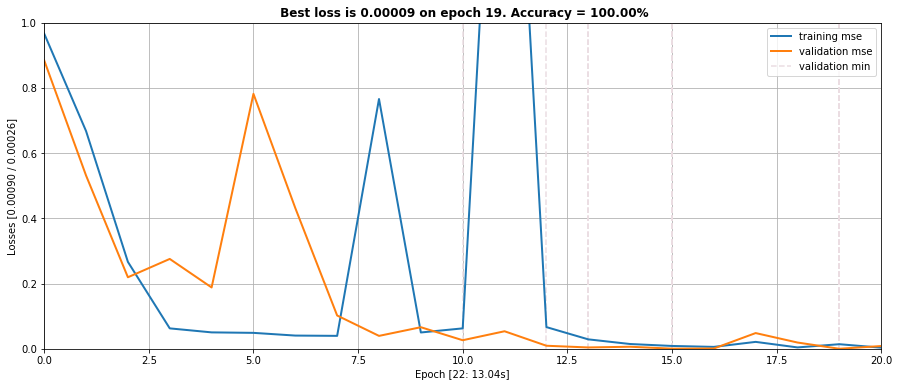

In [13]:
train_steps = n_train_words // (batch_size * seq_size)
valid_steps = n_valid_words // (batch_size * seq_size)

fit_params = {
    'train_steps':     train_steps,
    'valid_steps':     valid_steps,
    'opt':             'adam',      #SGD(lr=0.001, momentum=0.9, nesterov=True), 
    'nepochs':         20, 
    'patience':        50,
    'ploss':           1.0,
    'reset':           False,
}

train_network(model, model_name, train_gen(), valid_gen(), **fit_params);

In [14]:
test_network(model_name, valid_gen(), valid_steps)

Model from epoch 19
[INFO] evaluating in the test data set ...

[INFO] accuracy on the test data set: 100.00% [0.00008]
